#### Train the Neural ODE with the analytical $\Psi$ from Govindjee

In [1]:
import jax.numpy as np
import numpy as onp
from NODE_fns import sigma_split_vmap, sigma_biaxial_vmap
from jax import grad, random, jit, vmap
from functools import partial
from jax.experimental import optimizers
import pickle
import matplotlib.pyplot as plt
key = random.PRNGKey(0)
from jax.config import config
config.update('jax_disable_jit', False)

/Users/vt/miniforge3/envs/jax/lib/python3.10/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '


In [2]:
# Initialize parameters
def init_params(layers, key):
    Ws = []
    for i in range(len(layers) - 1):
        std_glorot = np.sqrt(2/(layers[i] + layers[i + 1]))
        key, subkey = random.split(key)
        Ws.append(random.normal(subkey, (layers[i], layers[i + 1]))*std_glorot)
    return Ws

layers = [1, 5, 5, 1]
I1_params = init_params(layers, key)
I2_params = init_params(layers, key)
J1_params = init_params(layers, key)
alpha = 1.0
Psi1_bias = -3.0
Psi2_bias = -3.0
NN_weights = (I1_params, I2_params, J1_params)
params = (NN_weights, alpha, Psi1_bias, Psi2_bias)

In [3]:
def loss(params, lmb, sigma_gt):
    lm1 = lmb[:,0]
    lm2 = lmb[:,1]
    lm3 = lmb[:,2]
    sigma_pr = sigma_split_vmap(lm1, lm2, lm3, params)
    loss1 = np.average((sigma_pr[:,0,0]-sigma_gt[:,0,0])**2) 
    loss2 = np.average((sigma_pr[:,1,1]-sigma_gt[:,1,1])**2)
    loss = (loss1+loss2)/2
    return  loss

@partial(jit, static_argnums=(0,))
def step(loss, i, opt_state, X_batch, Y_batch):
    params = get_params(opt_state)
    g = grad(loss)(params, X_batch, Y_batch)
    return opt_update(i, g, opt_state)

def train(loss, X, Y, opt_state, key, nIter = 10000, batch_size = 10):
    train_loss = []
    val_loss = []
    for it in range(nIter):
        key, subkey = random.split(key)
        idx_batch = random.choice(subkey, X.shape[0], shape = (batch_size,), replace = False)
        opt_state = step(loss, it, opt_state, X[idx_batch], Y[idx_batch])         
        if (it+1)% 10000 == 0:
            params = get_params(opt_state)
            train_loss_value = loss(params, X, Y)
            train_loss.append(train_loss_value)
            to_print = "it %i, train loss = %e" % (it+1, train_loss_value)
            print(to_print)
    return get_params(opt_state), train_loss, val_loss

In [4]:
# Generate input data
lm = np.linspace(0.9,1.2,20)
lm1, lm2 = np.array(np.meshgrid(lm, lm))
lm1 = lm1.reshape(-1)
lm2 = lm2.reshape(-1)
lm3 = 1/(lm1*lm2)
lmb = np.transpose(np.array([lm1, lm2, lm3]))

In [5]:
# Generate output data
mu = 77.77 #=shear_mod
K = 10000
sigma_gt = []
for i in range(lm1.shape[0]):
    b = np.array([[lm1[i]**2, 0, 0],
                  [0, lm2[i]**2, 0],
                  [0, 0, lm3[i]**2]])
    J = lm1[i]*lm2[i]*lm3[i]
    sigma_gt.append(mu/J*(b-np.eye(3)) + 2*K*(J-1)*np.eye(3))
sigma_gt = np.stack(sigma_gt)

In [8]:
# Train
opt_init, opt_update, get_params = optimizers.adam(1.e-5)
opt_state = opt_init(params)
params_Psi_eq, train_loss, val_loss = train(loss, lmb, sigma_gt, opt_state, key, nIter = 50000, batch_size = 10)
with open('saved/Psi_eq_params.npy', 'wb') as f:
    pickle.dump(params_Psi_eq, f)

it 10000, train loss = 1.428288e+00
it 20000, train loss = 1.258111e+00
it 30000, train loss = 1.227393e+00
it 40000, train loss = 1.217305e+00
it 50000, train loss = 1.212150e+00


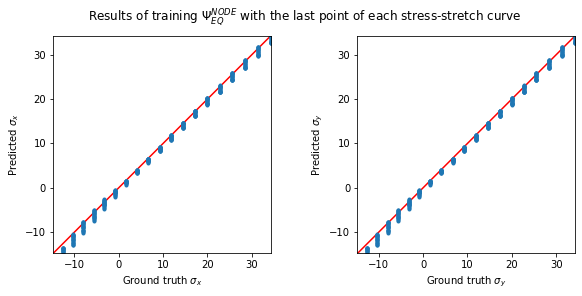

In [9]:
# Make predictions with the newly trained Neural ODEs
sigma_pr = sigma_split_vmap(lm1, lm2, lm3, params_Psi_eq)
xmin,xmax = np.min(sigma_gt[:,0,0]), np.max(sigma_gt[:,0,0])
ymin,ymax = np.min(sigma_gt[:,1,1]), np.max(sigma_gt[:,1,1])
zmin,zmax = np.min(sigma_gt[:,2,2]), np.max(sigma_gt[:,2,2])

fig,ax = plt.subplots(1,2, figsize=[10,4])
ax[0].plot([xmin, xmax], [xmin, xmax], 'r-')
ax[0].plot(sigma_gt[:,0,0],sigma_pr[:,0,0],'.')
ax[1].plot([ymin, ymax], [ymin, ymax], 'r-')
ax[1].plot(sigma_gt[:,1,1],sigma_pr[:,1,1],'.')

fig.suptitle(r"Results of training $\Psi_{EQ}^{NODE}$ with the last point of each stress-stretch curve")
ax[0].set(xlabel="Ground truth $\sigma_x$", ylabel='Predicted $\sigma_x$', aspect='equal', xlim=[xmin, xmax], ylim=[xmin, xmax])
ax[1].set(xlabel="Ground truth $\sigma_y$", ylabel='Predicted $\sigma_y$', aspect='equal', xlim=[ymin, ymax], ylim=[ymin, ymax])
fig.savefig('figs/train_Psi_eq.jpg')

#### Train $\Psi_{NEQ}$

##### Restart the kernel before proceding beyond this point

In [ ]:
import jax.numpy as np
import numpy as onp
from NODE_fns import sigma_split_vmap, sigma_biaxial_vmap
from jax import grad, random, jit, vmap
from functools import partial
from jax.experimental import optimizers
import pickle
import matplotlib.pyplot as plt
key = random.PRNGKey(0)
from jax.config import config
config.update('jax_disable_jit', False)

# Initialize parameters
def init_params(layers, key):
    Ws = []
    for i in range(len(layers) - 1):
        std_glorot = np.sqrt(2/(layers[i] + layers[i + 1]))
        key, subkey = random.split(key)
        Ws.append(random.normal(subkey, (layers[i], layers[i + 1]))*std_glorot)
    return Ws

layers = [1, 5, 5, 1]
I1_params = init_params(layers, key)
I2_params = init_params(layers, key)
J1_params = init_params(layers, key)
alpha = 1.0
Psi1_bias = -3.0
Psi2_bias = -3.0
NN_weights = (I1_params, I2_params, J1_params)
params = (NN_weights, alpha, Psi1_bias, Psi2_bias)

def loss(params, lmb, sigma_gt):
    lm1 = lmb[:,0]
    lm2 = lmb[:,1]
    lm3 = lmb[:,2]
    sigma_pr = sigma_split_vmap(lm1, lm2, lm3, params)
    loss1 = np.average((sigma_pr[:,0,0]-sigma_gt[:,0,0])**2) 
    loss2 = np.average((sigma_pr[:,1,1]-sigma_gt[:,1,1])**2)
    loss = (loss1+loss2)/2
    return  loss

@partial(jit, static_argnums=(0,))
def step(loss, i, opt_state, X_batch, Y_batch):
    params = get_params(opt_state)
    g = grad(loss)(params, X_batch, Y_batch)
    return opt_update(i, g, opt_state)

def train(loss, X, Y, opt_state, key, nIter = 10000, batch_size = 10):
    train_loss = []
    val_loss = []
    for it in range(nIter):
        key, subkey = random.split(key)
        idx_batch = random.choice(subkey, X.shape[0], shape = (batch_size,), replace = False)
        opt_state = step(loss, it, opt_state, X[idx_batch], Y[idx_batch])         
        if (it+1)% 10000 == 0:
            params = get_params(opt_state)
            train_loss_value = loss(params, X, Y)
            train_loss.append(train_loss_value)
            to_print = "it %i, train loss = %e" % (it+1, train_loss_value)
            print(to_print)
    return get_params(opt_state), train_loss, val_loss

# Generate input data
lm = np.linspace(0.9,1.2,20)
lm1, lm2 = np.array(np.meshgrid(lm, lm))
lm1 = lm1.reshape(-1)
lm2 = lm2.reshape(-1)
lm3 = 1/(lm1*lm2)
lmb = np.transpose(np.array([lm1, lm2, lm3]))

In [16]:
mu_m = np.array([51.4, -18, 3.86])
alpha_m = np.array([1.8, -2, 7])
K_m = 10000
def sigma_NEQ_gov(lm1, lm2, lm3):
    J = lm1*lm2*lm3

    lm1 = J**(-1/3)*lm1
    lm2 = J**(-1/3)*lm2
    lm3 = J**(-1/3)*lm3
    sigma11 = 0
    sigma22 = 0
    sigma33 = 0
    for i in range(3):
        sigma11+= mu_m[i]*lm1**(alpha_m[i]-1)
        sigma22+= mu_m[i]*lm2**(alpha_m[i]-1)
        sigma33+= mu_m[i]*lm3**(alpha_m[i]-1)
    sigma = np.array([[sigma11, 0, 0],
                      [0, sigma22, 0],
                      [0, 0, sigma33]])
    sigma = sigma/J

    p = 1/3*(sigma11 + sigma22 + sigma33)
    sigma = sigma - p

    sigma_vol = K_m/2*(J**2-1)*np.eye(3)
    sigma = sigma + sigma_vol
    return sigma
sigma_NEQ_vmap = vmap(sigma_NEQ_gov, in_axes=(0,0,0), out_axes=0)

sigma_gt = sigma_NEQ_vmap(lm1, lm2, lm3)

In [18]:
opt_init, opt_update, get_params = optimizers.adam(1.e-4)
opt_state = opt_init(params)
params_Psi_neq, train_loss, val_loss = train(loss, lmb, sigma_gt, opt_state, key, nIter = 100000, batch_size = 10)
with open('saved/Psi_neq_params.npy', 'wb') as f:
    pickle.dump(params_Psi_neq, f)

it 10000, train loss = 1.233523e-02
it 20000, train loss = 1.061651e-02
it 30000, train loss = 1.003656e-02
it 40000, train loss = 1.017158e-02
it 50000, train loss = 1.214133e-02
it 60000, train loss = 2.623527e-02
it 70000, train loss = 9.449257e-03
it 80000, train loss = 1.039581e-02
it 90000, train loss = 1.831980e-02
it 100000, train loss = 1.013744e-02


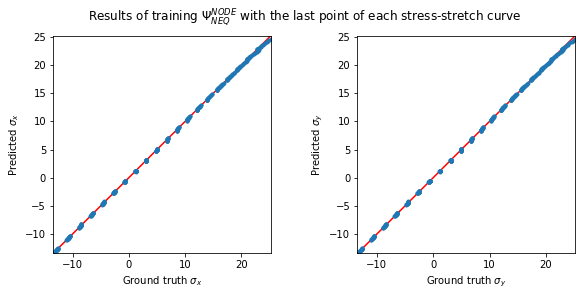

In [19]:
sigma_pr = sigma_split_vmap(lm1, lm2, lm3, params_Psi_neq)
xmin,xmax = np.min(sigma_gt[:,0,0]), np.max(sigma_gt[:,0,0])
ymin,ymax = np.min(sigma_gt[:,1,1]), np.max(sigma_gt[:,1,1])
zmin,zmax = np.min(sigma_gt[:,2,2]), np.max(sigma_gt[:,2,2])

fig,ax = plt.subplots(1,2, figsize=[10,4])
ax[0].plot([xmin, xmax], [xmin, xmax], 'r-')
ax[0].plot(sigma_gt[:,0,0],sigma_pr[:,0,0],'.')
ax[1].plot([ymin, ymax], [ymin, ymax], 'r-')
ax[1].plot(sigma_gt[:,1,1],sigma_pr[:,1,1],'.')

fig.suptitle(r"Results of training $\Psi_{NEQ}^{NODE}$ with the last point of each stress-stretch curve")
ax[0].set(xlabel="Ground truth $\sigma_x$", ylabel='Predicted $\sigma_x$', aspect='equal', xlim=[xmin, xmax], ylim=[xmin, xmax])
ax[1].set(xlabel="Ground truth $\sigma_y$", ylabel='Predicted $\sigma_y$', aspect='equal', xlim=[ymin, ymax], ylim=[ymin, ymax])
fig.savefig('figs/train_Psi_neq.jpg')